# Active Learning for Text Classification using Small-Text: Stopping Criteria

*Notebook 2*  
This tutorial shows how to use stopping criteria when performing active learning for text classification using [small-text](https://github.com/webis-de/small-text). If you have read the previous notebook already, you can also directly jump to the [relevant section regarding stopping criteria](#nb2-part4-stopping).

----

## Overview

- [Part I: Installation](#nb2-part1-installation)
- [Part II: Loading and Preparing the Data](#nb2-part2-data)
- [Part III: Active Learning](#nb2-part3-active-learning)
- [Part IV: Stopping Criterion](#nb2-part4-stopping)
- [Part V: Visualization](#nb2-part5-visualization)

----
<a id="nb2-part1-installation"></a>
## I. Installation

Besides small-text, we also install [datasets](https://github.com/huggingface/datasets) to load an example dataset and [matptlotlib](https://matplotlib.org/) to plot the learning curves at the end.

In [1]:
%pip install small-text[transformers]==1.4.1

# additional dependencies for this example
%pip install datasets matplotlib "seaborn>=0.13.0" pandas

DEPRECATION: git+https://github.com/webis-de/small-text.git@v1.4.x#egg=small-text[transformers] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Cloning https://github.com/webis-de/small-text.git (to revision v1.4.x) to /tmp/pip-install-jqcghh9f/small-text_c224a8e235f04e349ce325ef5180ca7c
  Running command git clone --filter=blob:none --quiet https://github.com/webis-de/small-text.git /tmp/pip-install-jqcghh9f/small-text_c224a8e235f04e349ce325ef5180ca7c
  Running command git checkout -b v1.4.x --track origin/v1.4.x
  Switched to a new branch 'v1.4.x'
  branch 'v1.4.x' set up to track 'origin/v1.4.x'.
  Resolved https://github.com/webis-de/small-text.git to commit 1193e540f1317ef589393541b428b2cb4716cc3a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done


The code in the following cell sets the logging level and progress bars to make it suitable for notebooks. Moreover, we set a fixed random seed, so you get the same output every time you run this notebook.

In [2]:
import datasets
import torch
import warnings

import numpy as np

from matplotlib import rcParams

datasets.logging.set_verbosity_error()

# disables the progress bar for notebooks: https://github.com/huggingface/datasets/issues/2651
datasets.logging.get_verbosity = lambda: logging.NOTSET

# set matplotlib params
rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.labelsize': 16})

# fix the random seed
seed = 2022
torch.manual_seed(seed)
np.random.seed(seed)

warnings.filterwarnings(action='ignore', category=FutureWarning, message=r'.*`clean_up_tokenization_spaces` was not set..*')

----

<a id="nb2-part2-data"></a>
## II. Loading and Preparing the Data

Again, we load the rotten tomatoes dataset and build a TransformersDataset object which is then used for active learning.

In [3]:
import logging
import numpy as np


from transformers import AutoTokenizer

from small_text import TransformersDataset


raw_dataset = datasets.load_dataset('rotten_tomatoes')
num_classes = raw_dataset['train'].features['label'].num_classes

transformer_model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(
    transformer_model_name
)


target_labels = np.arange(num_classes)

train = TransformersDataset.from_arrays(raw_dataset['train']['text'],
                                        raw_dataset['train']['label'],
                                        tokenizer,
                                        max_length=60,
                                        target_labels=target_labels)
test = TransformersDataset.from_arrays(raw_dataset['test']['text'], 
                                       raw_dataset['test']['label'],
                                       tokenizer,
                                       max_length=60,
                                       target_labels=target_labels)

/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/utils/annotations.py:67: ExperimentalWarning: The function from_arrays is experimental and maybe subject to change soon.
  warnings.warn(f'The {subject} {func_or_class.__name__} is experimental '


----

<a id="nb2-part3-active-learning"></a>
## III. Active Learning

Now we set up an active learning example that uses transformer models.

In [4]:
from small_text import (
    PoolBasedActiveLearner,
    PredictionEntropy,
    TransformerBasedClassificationFactory,
    TransformerModelArguments,
    random_initialization_balanced
)


# simulates an initial labeling to warm-start the active learning process
def initialize_active_learner(active_learner, y_train):

    indices_initial = random_initialization_balanced(y_train, n_samples=20)
    active_learner.initialize_data(indices_initial, y_train[indices_initial])

    return indices_initial


transformer_model = TransformerModelArguments(transformer_model_name)
clf_factory = TransformerBasedClassificationFactory(transformer_model, 
                                                    num_classes, 
                                                    kwargs={
                                                        'device': 'cuda', 
                                                        'mini_batch_size': 32,
                                                        'class_weight': 'balanced'
                                                    })
query_strategy = PredictionEntropy()

active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train)
indices_labeled = initialize_active_learner(active_learner, train.y)

----

<a id="nb2-part4-stopping"></a>
## IV. Stopping Criterion

Besides, we slightly change the evaluation: in order to make the setting more realistic, we do not evaluate on the test accuracy any longer, since you will not have a test set in real-world situations. 

Unlike before, we now also output the stopping response (True or False). The stopping criteria are not bound to the PoolBasedActiveLearner class because in real-world applications a user should have the final say whether the active learning process is stopped or not. Stopping criteria are intended to be an indicator, whose recommendation can be accepted or rejected.

In [5]:
from sklearn.metrics import accuracy_score
from small_text import KappaAverage


num_queries = 30
stopping_criterion = KappaAverage(num_classes, kappa=0.8)


def evaluate(active_learner, train, test):
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)
    
    # Notice: We observe the train accuracy now.
    train_acc = accuracy_score(y_pred, train.y)

    print('Train accuracy: {:.2f}'.format(train_acc))
    print('Test accuracy: {:.2f}'.format(accuracy_score(y_pred_test, test.y)))
    
    return train_acc


results = []
stopping_history = []

results.append(evaluate(active_learner, train[indices_labeled], test))
stopping_history.append(stopping_criterion.stop(predictions=active_learner.classifier.predict(train)))


for i in range(num_queries):
    # ...where each iteration consists of labelling 20 samples
    indices_queried = active_learner.query(num_samples=20)

    # Simulate user interaction here. Replace this for real-world usage.
    y = train.y[indices_queried]

    # Return the labels for the current query to the active learner.
    active_learner.update(y)

    indices_labeled = np.concatenate([indices_queried, indices_labeled])
    
    print('---------------')
    print(f'Iteration #{i} ({len(indices_labeled)} samples)')
    results.append(evaluate(active_learner, train[indices_labeled], test))
    
    stopping_criterion_response = stopping_criterion.stop(predictions=active_learner.classifier.predict(train))
    print(f'Stop: {stopping_criterion_response}')
    stopping_history.append(stopping_criterion_response)
 

Train accuracy: 0.65
Test accuracy: 0.53
---------------
Iteration #0 (40 samples)
Train accuracy: 0.90
Test accuracy: 0.52
Stop: False
---------------
Iteration #1 (60 samples)
Train accuracy: 0.92
Test accuracy: 0.60
Stop: False
---------------
Iteration #2 (80 samples)
Train accuracy: 0.99
Test accuracy: 0.68
Stop: False
---------------
Iteration #3 (100 samples)
Train accuracy: 0.97
Test accuracy: 0.73
Stop: False
---------------
Iteration #4 (120 samples)
Train accuracy: 0.78
Test accuracy: 0.59
Stop: False
---------------
Iteration #5 (140 samples)
Train accuracy: 0.95
Test accuracy: 0.70
Stop: False
---------------
Iteration #6 (160 samples)
Train accuracy: 0.96
Test accuracy: 0.72
Stop: False
---------------
Iteration #7 (180 samples)
Train accuracy: 0.96
Test accuracy: 0.71
Stop: False
---------------
Iteration #8 (200 samples)
Train accuracy: 0.95
Test accuracy: 0.78
Stop: False
---------------
Iteration #9 (220 samples)
Train accuracy: 0.98
Test accuracy: 0.77
Stop: False
--

----

<a name="nb2-part5-visualization"></a>
## V. Visualization

You can use the learning curve plot, which now depicts the learning curve of the training accuracy, to visualize the earliest iteration at which the stopping criterion returned `True`.

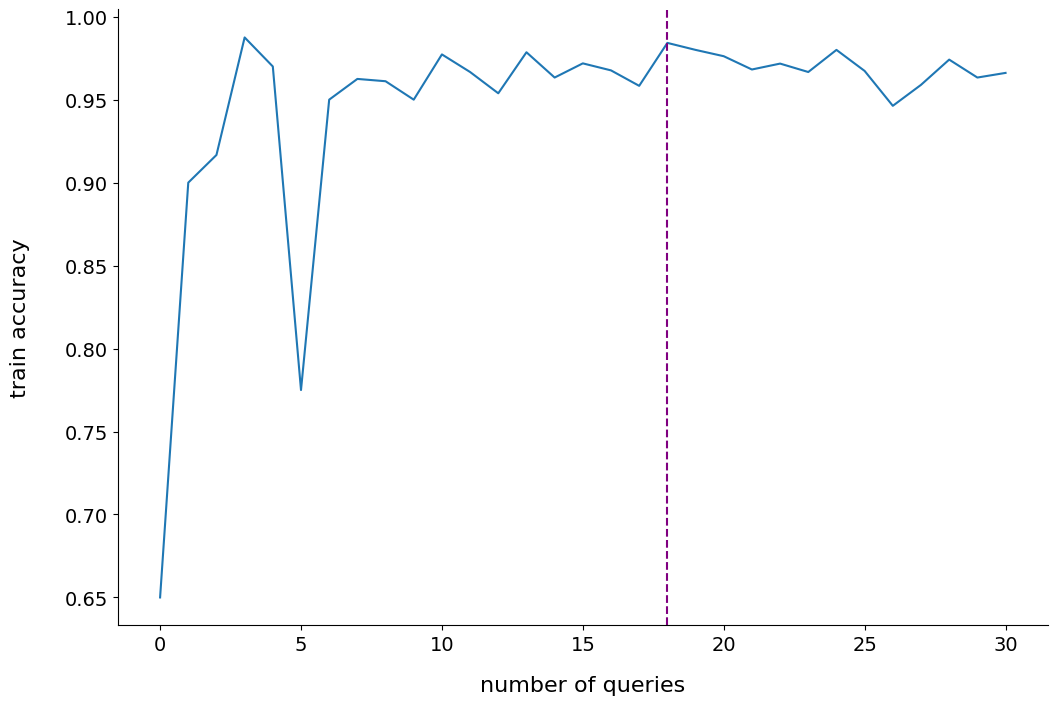

In [6]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

data = np.array([np.arange(num_queries+1), np.array(results)]).T
df = pd.DataFrame(data, columns=['query', 'accuracy'])
sns.lineplot(x='query', y='accuracy', data=df)

plt.xlabel('number of queries', labelpad=15)
plt.ylabel('train accuracy', labelpad=25)

earliest_stopping_response = np.amin([i for i, _ in enumerate(stopping_history) if stopping_history[i] is True])
plt.axvline(x=earliest_stopping_response, ymin=0, ymax=1, color='purple', ls='--')

sns.despine()